In [3]:
# info for csv files (optional)

import polars as pl

df = pl.scan_csv(r'C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\vehicle_pnid_mapping.csv')
print(df.describe()) # fast summary stats
print(df.schema) # column names + dtypes
print(df.select(pl.all().null_count())) # null counts without full load

shape: (9, 4)
┌────────────┬──────────┬─────────────────────────────────┬────────────────┐
│ statistic  ┆          ┆ ID                              ┆ IDS            │
│ ---        ┆ ---      ┆ ---                             ┆ ---            │
│ str        ┆ f64      ┆ str                             ┆ str            │
╞════════════╪══════════╪═════════════════════════════════╪════════════════╡
│ count      ┆ 19.0     ┆ 19                              ┆ 13             │
│ null_count ┆ 0.0      ┆ 0                               ┆ 6              │
│ mean       ┆ 5.842105 ┆ null                            ┆ null           │
│ std        ┆ 4.597864 ┆ null                            ┆ null           │
│ min        ┆ 0.0      ┆ 026af092-a01e-4b0a-af38-f45972… ┆ [              │
│            ┆          ┆                                 ┆   "197443154", │
│            ┆          ┆                                 ┆   "197443158"… │
│ 25%        ┆ 2.0      ┆ null                            ┆ nu

C:\Users\aniruktha\AppData\Local\Temp\ipykernel_29948\1623172686.py:5: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  print(df.schema) # column names + dtypes


In [2]:
# info for json files (optional)

import ijson
from collections import Counter
from datetime import datetime

file_path = r"C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\artificial_ign_off_data.json" # ← change to your actual file name

total_count = 0
vehicle_counter = Counter()
type_counter = Counter()
min_ts = None
max_ts = None
parse_fail_ts = 0
bad_structure = 0

with open(file_path, 'rb') as f:  # binary mode for efficiency
    parser = ijson.parse(f)
    
    current_item = {}
    in_item = False
    
    for prefix, event, value in parser:
        if prefix == 'item' and event == 'start_map':
            in_item = True
            current_item = {}
        
        elif prefix.startswith('item.') and in_item:
            key = prefix.split('.')[-1]
            current_item[key] = value
        
        elif prefix == 'item' and event == 'end_map':
            in_item = False
            total_count += 1
            
            # Process the item
            vid = current_item.get('vehicleId')
            ts_str = current_item.get('timestamp')
            typ = current_item.get('type')
            
            if vid:
                vehicle_counter[vid] += 1
            if typ:
                type_counter[typ] += 1
            
            if ts_str:
                try:
                    dt = datetime.fromisoformat(ts_str.replace('Z', '+00:00'))
                    if min_ts is None or dt < min_ts:
                        min_ts = dt
                    if max_ts is None or dt > max_ts:
                        max_ts = dt
                except (ValueError, TypeError):
                    parse_fail_ts += 1
            
            # Check structure
            if set(current_item.keys()) != {'vehicleId', 'timestamp', 'type'}:
                bad_structure += 1
            
            # Optional: early stop for testing
            # if total_count >= 100000: break

print(f"Total valid entries processed: {total_count:,}")
print(f"Unique vehicleIds: {len(vehicle_counter):,}")
if vehicle_counter:
    print("Top 5 vehicles by event count:", vehicle_counter.most_common(5))
print(f"Type distribution: {dict(type_counter)}")
print(f"Time range: {min_ts} → {max_ts}")
print(f"Timestamp parse failures: {parse_fail_ts}")
print(f"Items with unexpected structure (missing/extra keys): {bad_structure}")

Total valid entries processed: 411
Unique vehicleIds: 11
Top 5 vehicles by event count: [('f0704100-56e6-4117-ae4f-cf97e5d2d132', 96), ('4d210a10-6c23-41c4-92e1-5b1833f7b54a', 53), ('9893c80d-f282-46cf-a794-280f0306c936', 46), ('66bd55df-eaf0-49c8-b9e1-7759b85e9325', 45), ('3e937810-3a3b-48d6-80ad-56ae12c3bed8', 40)]
Type distribution: {'artificial_event': 411}
Time range: 2021-12-18 18:53:37.067000+00:00 → 2022-01-31 19:13:06.001000+00:00
Timestamp parse failures: 0
Items with unexpected structure (missing/extra keys): 0


In [38]:
# step - 1 cleaning - 03 

import polars as pl
import json
import os
from datetime import datetime
from pathlib import Path

# ─── CONFIG ────────────────────────────────────────────────────────────────
BASE_DIR = r"C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024"
INPUT_DIR = Path(BASE_DIR)
OUTPUT_DIR = INPUT_DIR / "processed"
OUTPUT_DIR.mkdir(exist_ok=True)

class MotorqSanityEngine:
    def __init__(self):
        self.base_date = "2021-12-01"

    def process_mapping(self):
        print("[-] Processing Mapping...")
        df = pl.read_csv(INPUT_DIR / "vehicle_pnid_mapping.csv")

        def safe_json(s):
            try: 
                # Remove escaped backslashes and load
                return json.loads(s.replace('\\', '')) if s else []
            except: 
                return []

        mapping = (
            df.filter(pl.col("IDS").is_not_null())
              .with_columns(pl.col("IDS").map_elements(safe_json, return_dtype=pl.List(pl.String)).alias("pnid"))
              .explode("pnid")
              # Ensure pnid is string and stripped of whitespace for clean joining
              .with_columns(pl.col("pnid").cast(pl.String).str.strip_chars())
              .select([pl.col("ID").alias("vehicle_id"), "pnid"])
              .unique()
        )
        mapping.write_parquet(OUTPUT_DIR / "mapping.parquet")
        return mapping

    def process_syn(self):
        print("[-] Processing SYN (Artificial Data)...")
        with open(INPUT_DIR / "artificial_ign_off_data.json", "r") as f:
            data = json.load(f)

        df = pl.from_dicts(data).with_columns(
            pl.col("timestamp").str.to_datetime(format="%Y-%m-%dT%H:%M:%S.%3fZ", strict=False).alias("event_ts")
        ).rename({"vehicleId": "vehicle_id"})

        df.write_parquet(OUTPUT_DIR / "syn_clean.parquet")
        return df

    def process_trg(self, map_df):
        print("[-] Processing TRG (Triggers)...")
        # Ensure mapping is ready for lazy join
        map_lazy = map_df.lazy()

        q = pl.scan_csv(INPUT_DIR / "triggers_soc.csv", schema_overrides={"PNID": pl.String})

        q = q.with_columns([
            # 1. Fix Scientific Notation (e.g., 2.07E8 -> 207000000)
            pl.col("PNID").map_elements(
                lambda s: str(int(float(s))) if s and ("E" in s.upper() or "." in s) else s, 
                return_dtype=pl.String
            ).str.strip_chars(),
            
            # 2. Convert to UTC
            pl.col("CTS").str.to_datetime(format="%Y-%m-%d %H:%M:%S IST%z", strict=False)
              .dt.convert_time_zone("UTC").alias("ts_utc")
        ])

        # 3. Join with Mapping (INNER JOIN to prevent Null Vehicle IDs)
        q = q.join(map_lazy, left_on="PNID", right_on="pnid", how="inner")

        # Deduplicate triggers
        q = q.unique(subset=["ts_utc", "vehicle_id", "NAME", "VAL"])

        res = q.collect(streaming=True)
        print(f"TRG Cleaned: {res.height} records mapped to vehicles.")
        res.write_parquet(OUTPUT_DIR / "trg_clean.parquet")

    def process_tlm(self):
        print("[-] Processing TLM (High Scale Telemetry)...")
        q = pl.scan_csv(INPUT_DIR / "telemetry_data.csv", infer_schema_length=10000)

        # Step 1: Fix Relative Timestamps (MM:SS.f -> YYYY-MM-DD 00:MM:SS.f)
        q = q.with_columns(
            pl.when(pl.col("TIMESTAMP").str.len_chars() <= 12)
              .then(pl.lit(f"{self.base_date} 00:") + pl.col("TIMESTAMP"))
              .otherwise(pl.col("TIMESTAMP"))
              .alias("ts_normalized")
        )

        # Step 2: Robust Multi-Format Parsing
        q = q.with_columns(
            pl.col("ts_normalized")
              .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S.%f", strict=False)
              .fill_null(pl.col("ts_normalized").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False))
              .fill_null(pl.col("ts_normalized").str.strptime(pl.Datetime, "%d-%m-%Y %H:%M", strict=False))
              .fill_null(pl.col("ts_normalized").str.strptime(pl.Datetime, "%d-%m-%Y %H:%M:%S", strict=False))
              .alias("ts_utc")
        )

        # Filter failed parses and sort for Join_Asof preparation
        q = q.filter(pl.col("ts_utc").is_not_null()).sort(["VEHICLE_ID", "ts_utc"])

        # Step 3: Sanity Logic (Odometer & Battery)
        q = q.with_columns([
            pl.col("EV_BATTERY_LEVEL").cast(pl.Float64).clip(0, 100).alias("EV_BATTERY_LEVEL"),
            # Nullify odometer if it backtracks (per vehicle)
            pl.when(pl.col("ODOMETER").diff().over("VEHICLE_ID") < 0)
              .then(None)
              .otherwise(pl.col("ODOMETER"))
              .alias("ODOMETER"),
            pl.col("SPEED").cast(pl.Float64).clip(0, 250)
        ])

        # Step 4: Final selection
        final_q = q.select([
            pl.col("VEHICLE_ID").alias("vehicle_id"),
            "ts_utc",
            "IGNITION_STATUS",
            "EV_BATTERY_LEVEL",
            "ODOMETER"
        ])

        # Use sink_parquet for memory efficiency on 1.8M rows
        print("Sinking TLM to parquet...")
        final_q.sink_parquet(OUTPUT_DIR / "tlm_clean.parquet")
        print("TLM Processing Complete.")

    def run(self):
        start_time = datetime.now()
        map_df = self.process_mapping()
        self.process_syn()
        self.process_trg(map_df)
        self.process_tlm()
        
        duration = datetime.now() - start_time
        print(f"\n[SUCCESS] Pipeline completed in {duration}")
        print(f"Processed files are located in: {OUTPUT_DIR}")

if __name__ == "__main__":
    MotorqSanityEngine().run()

[-] Processing Mapping...
[-] Processing SYN (Artificial Data)...
[-] Processing TRG (Triggers)...


C:\Users\aniruktha\AppData\Local\Temp\ipykernel_33980\2195448288.py:79: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  res = q.collect(streaming=True)


TRG Cleaned: 19781 records mapped to vehicles.
[-] Processing TLM (High Scale Telemetry)...
Sinking TLM to parquet...


C:\Users\aniruktha\AppData\Local\Temp\ipykernel_33980\2195448288.py:98: ChronoFormatWarning: Detected the pattern `.%f` in the chrono format string. This pattern should not be used to parse values after a decimal point. Use `%.f` instead. See the full specification: https://docs.rs/chrono/latest/chrono/format/strftime
  .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S.%f", strict=False)


TLM Processing Complete.

[SUCCESS] Pipeline completed in 0:00:03.625282
Processed files are located in: C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed


In [46]:
#step - 02 - ignition events

import polars as pl
import os
from pathlib import Path

PROCESSED_DIR = Path(r"C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed")
OUTPUT_FILE_CSV = PROCESSED_DIR / "IgnitionEvents.csv"
OUTPUT_FILE_PARQUET = PROCESSED_DIR / "IgnitionEvents.parquet"

# Deduplication window (seconds)
DEDUP_WINDOW_SEC = 30

def extract_ignition_events():
    print("=" * 60)
    print("TASK 2: IGNITION EVENT EXTRACTION")
    print("=" * 60)

    def safe_load_parquet(name, filename):
        path = PROCESSED_DIR / filename
        if not path.exists():
            raise FileNotFoundError(f"Missing file: {path}")
        print(f"Loading {name} from {path}")
        df = pl.read_parquet(path)
        print(f"  Columns: {df.columns}")
        if "event_ts" in df.columns or "ts_utc" in df.columns:
            ts_col = "event_ts" if "event_ts" in df.columns else "ts_utc"
            print(f"  {ts_col} type: {df[ts_col].dtype}")
        return df

    # ─── 1. TLM ────────────────────────────────────────────────────────────────
    print("Processing TLM state changes...")
    tlm = safe_load_parquet("TLM", "tlm_clean.parquet")

    # Rename VEHICLE_ID → vehicle_id if needed
    if "VEHICLE_ID" in tlm.columns:
        tlm = tlm.rename({"VEHICLE_ID": "vehicle_id"})

    tlm_events = (
        tlm.sort(["vehicle_id", "ts_utc"])
        .with_columns(pl.col("IGNITION_STATUS").forward_fill().over("vehicle_id"))
        .with_columns(pl.col("IGNITION_STATUS").shift(1).over("vehicle_id").alias("prev_status"))
        .filter(
            (pl.col("IGNITION_STATUS") != pl.col("prev_status")) &
            (pl.col("prev_status").is_not_null())
        )
        .with_columns(
            pl.when(pl.col("IGNITION_STATUS").str.to_lowercase().str.contains(r"on|1|true"))
              .then(pl.lit("ignitionOn"))
              .when(pl.col("IGNITION_STATUS").str.to_lowercase().str.contains(r"off|0|false"))
              .then(pl.lit("ignitionOff"))
              .otherwise(None)
              .alias("event")
        )
        .filter(pl.col("event").is_not_null())
        .select([
            "vehicle_id",
            "event",
            pl.col("ts_utc").alias("event_ts")
        ])
        .with_columns(pl.lit("TLM").alias("source"))
    )
    print(f"    TLM Events Found: {tlm_events.height:,}")

    # ─── 2. TRG ────────────────────────────────────────────────────────────────
    print("Processing TRG trigger logs...")
    trg = safe_load_parquet("TRG", "trg_clean.parquet")

    trg_events = (
        trg.filter(pl.col("NAME") == "IGN_CYL")
        .with_columns(
            pl.when(pl.col("VAL").str.to_uppercase() == "ON")
              .then(pl.lit("ignitionOn"))
              .when(pl.col("VAL").str.to_uppercase() == "OFF")
              .then(pl.lit("ignitionOff"))
              .otherwise(None)
              .alias("event")
        )
        .filter(pl.col("event").is_not_null())
        .select([
            "vehicle_id",
            "event",
            pl.col("ts_utc").alias("event_ts")
        ])
        .with_columns(pl.lit("TRG").alias("source"))
    )
    print(f"    TRG Events Found: {trg_events.height:,}")

    # ─── 3. SYN ────────────────────────────────────────────────────────────────
    print("Processing SYN overrides...")
    syn = safe_load_parquet("SYN", "syn_clean.parquet")

    syn_events = (
        syn.select([
            pl.col("vehicle_id").alias("vehicle_id"),
            pl.col("type").alias("event"),
            pl.col("event_ts")
        ])
        .with_columns(pl.lit("SYN").alias("source"))
    )
    print(f"    SYN Events Found: {syn_events.height:,}")

    # ─── 4. FUSION ─────────────────────────────────────────────────────────────
    print("Fusing sources and deduplicating...")

    # Standardize event_ts to EXACT same type: Datetime μs UTC
    def standardize_ts(df):
        if "event_ts" in df.columns:
            return df.with_columns(
                pl.col("event_ts")
                  .dt.replace_time_zone("UTC")
                  .cast(pl.Datetime(time_unit="us", time_zone="UTC"))
            )
        return df

    tlm_events = standardize_ts(tlm_events)
    trg_events = standardize_ts(trg_events)
    syn_events = standardize_ts(syn_events)

    # Debug types before concat
    print("Event_ts types before concat:")
    print("TLM:", tlm_events["event_ts"].dtype)
    print("TRG:", trg_events["event_ts"].dtype)
    print("SYN:", syn_events["event_ts"].dtype)

    # Combine
    all_events = pl.concat([tlm_events, trg_events, syn_events], how="vertical")

    # Assign priority (SYN highest)
    priority_map = {"SYN": 3, "TRG": 2, "TLM": 1}
    all_events = all_events.with_columns(
        pl.col("source").replace(priority_map).alias("priority")
    )

    # Cluster & deduplicate — keep highest priority in each window
    unified_events = (
        all_events
        .sort(["vehicle_id", "event_ts", "priority"], descending=[False, False, True])
        .with_columns(
            pl.col("event_ts").dt.round(f"{DEDUP_WINDOW_SEC}s").alias("cluster_ts")
        )
        .unique(subset=["vehicle_id", "event", "cluster_ts"], keep="first")
        .select(["vehicle_id", "event", "event_ts"])
    )

    # ─── OUTPUT ────────────────────────────────────────────────────────────────
    unified_events.write_csv(OUTPUT_FILE_CSV)
    unified_events.write_parquet(OUTPUT_FILE_PARQUET, compression="zstd")

    print("\n" + "="*60)
    print(f"SUCCESS: {unified_events.height:,} unique ignition events after fusion")
    print(f"Saved to:")
    print(f"  CSV: {OUTPUT_FILE_CSV}")
    print(f"  Parquet: {OUTPUT_FILE_PARQUET}")
    print("="*60)

    print("\nEvents by source (raw candidates):")
    print(all_events.group_by("source").len())

    print("\nFinal output preview (first 10 rows):")
    print(unified_events.head(10))

    return unified_events


if __name__ == "__main__":
    try:
        events = extract_ignition_events()
    except Exception as e:
        print(f"\nERROR during extraction: {e}")
        raise

TASK 2: IGNITION EVENT EXTRACTION
Processing TLM state changes...
Loading TLM from C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed\tlm_clean.parquet
  Columns: ['vehicle_id', 'ts_utc', 'IGNITION_STATUS', 'EV_BATTERY_LEVEL', 'ODOMETER']
  ts_utc type: Datetime(time_unit='us', time_zone=None)
    TLM Events Found: 8,362
Processing TRG trigger logs...
Loading TRG from C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed\trg_clean.parquet
  Columns: ['', 'CTS', 'PNID', 'NAME', 'VAL', 'ts_utc', 'vehicle_id']
  ts_utc type: Datetime(time_unit='us', time_zone='UTC')
    TRG Events Found: 8,292
Processing SYN overrides...
Loading SYN from C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed\syn_clean.parquet
  Columns: ['vehicle_id', 'timestamp', 'type', 'event_ts']
  event_ts type: Datetime(time_unit='ms'

In [47]:
# step - 3 charging event extraction

import polars as pl
import os

# Path to the cleaned trigger file from Phase 1
TRG_PATH = r"C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed\trg_clean.parquet"
OUTPUT_DIR = r"C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed"

def extract_charging_status():
    print("Milestone 3: Inferring Charging Status from TRG...")
    
    # 1. Load Triggers
    trg = pl.read_parquet(TRG_PATH)

    # 2. Filter for all charging-related triggers
    # We look for 'CHARGE_STATE' (numeric) and 'CHARGE_STATUS' (strings)
    charge_data = trg.filter(pl.col("NAME").str.contains("(?i)CHARGE")).sort(["vehicle_id", "ts_utc"])

    # 3. Handle Numeric Inference (Converting SoC changes to Status)
    # We identify the 'Start' (Active) and 'End' (Completed/Abort) of a charging sequence
    # by looking at gaps in time between triggers.
    
    # If the gap between two charging triggers is > 30 minutes, it's a new session.
    charge_data = charge_data.with_columns([
        (pl.col("ts_utc").diff().over("vehicle_id") > pl.duration(minutes=30)).alias("is_new_session"),
        pl.col("VAL").cast(pl.Float64, strict=False).alias("soc_val")
    ])

    # 4. Apply Mapping Logic
    # We'll label the first record of a session as 'Active'
    # And the last record as 'Completed' or 'Abort'
    
    # For this assignment, we will prioritize explicit strings if they exist, 
    # otherwise we use the start/end of the sequence.
    charging_events = (
        charge_data.with_columns([
            pl.when(pl.col("VAL").str.to_lowercase().str.contains("start|active"))
              .then(pl.lit("Active"))
              .when(pl.col("VAL").str.to_lowercase().str.contains("complete|finish|stop"))
              .then(pl.lit("Completed"))
              .when(pl.col("VAL").str.to_lowercase().str.contains("abort|fail|error"))
              .then(pl.lit("Abort"))
              # Fallback: If it's the first in a sequence, call it Active
              .when(pl.col("is_new_session") | pl.col("is_new_session").is_null())
              .then(pl.lit("Active"))
              .otherwise(None)
              .alias("event")
        ])
    )

    # 5. Final Formatting
    output = (
        charging_events.filter(pl.col("event").is_not_null())
        .select([
            pl.col("vehicle_id"),
            pl.col("event"),
            pl.col("ts_utc").alias("event_ts")
        ])
    )

    output.write_csv(os.path.join(OUTPUT_DIR, "ChargingStatusEvents.csv"))
    print(f"Milestone 3 Complete: {output.height} events extracted.")
    print(output.head(5))

if __name__ == "__main__":
    extract_charging_status()

Milestone 3: Inferring Charging Status from TRG...
Milestone 3 Complete: 4870 events extracted.
shape: (5, 3)
┌─────────────────────────────────┬───┐
│ vehicle_id                      ┆ … │
│ ---                             ┆   │
│ str                             ┆   │
╞═════════════════════════════════╪═══╡
│ 66bd55df-eaf0-49c8-b9e1-7759b8… ┆ … │
│ …                               ┆ … │
└─────────────────────────────────┴───┘


In [50]:
# step - 4 battery level association

import polars as pl
import os

# ─── CONFIGURATION ──────────────────────────────────────────────────────────
PROCESSED_DIR = r"C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed"

def associate_battery_levels():
    print("="*60)
    print("MILESTONE 4: BATTERY LEVEL ASSOCIATION")
    print("="*60)

    # 1. LOAD CANDIDATE EVENTS
    print("[-] Loading candidate events (Ignition + Charging)...")
    ign_path = os.path.join(PROCESSED_DIR, "IgnitionEvents.csv")
    chg_path = os.path.join(PROCESSED_DIR, "ChargingStatusEvents.csv")

    # FIX: Explicitly set time_zone="UTC" inside to_datetime to handle the string offset
    # Then use replace_time_zone(None) to make it Naive for the TLM join.
    ign_events = pl.read_csv(ign_path).with_columns(
        pl.col("event_ts")
        .str.to_datetime(time_zone="UTC", strict=False) # <--- CRITICAL FIX: Tell Polars the string has UTC data
        .dt.replace_time_zone(None)                     # Make it Naive
        .cast(pl.Datetime("us"))
    )
    
    chg_events = pl.read_csv(chg_path).with_columns(
        pl.col("event_ts")
        .str.to_datetime(time_zone="UTC", strict=False) # <--- CRITICAL FIX: Tell Polars the string has UTC data
        .dt.replace_time_zone(None)                     # Make it Naive
        .cast(pl.Datetime("us"))
    )

    # Combine events (Ensure both have same schema: vehicle_id, event, event_ts)
    all_candidates = pl.concat([
        ign_events.select(["vehicle_id", "event", "event_ts"]),
        chg_events.select(["vehicle_id", "event", "event_ts"])
    ]).sort(["vehicle_id", "event_ts"])

    # 2. LOAD TELEMETRY (Battery readings)
    print("[-] Loading telemetry battery logs...")
    tlm_path = os.path.join(PROCESSED_DIR, "tlm_clean.parquet")
    tlm = pl.read_parquet(tlm_path)
    
    # Ensure TLM is also Naive and sorted
    battery_readings = (
        tlm.filter(pl.col("EV_BATTERY_LEVEL").is_not_null())
        .select([
            pl.col("vehicle_id"), 
            pl.col("ts_utc").alias("battery_ts"),
            pl.col("EV_BATTERY_LEVEL")
        ])
        .with_columns(
            pl.col("battery_ts").dt.replace_time_zone(None).cast(pl.Datetime("us"))
        )
        .sort("battery_ts")
    )

    # 3. PERFORM THE "AS-OF" JOIN (The ±300s logic)
    print("[-] Performing nearest-neighbor join (Tolerance: 300s)...")
    
    associated_events = all_candidates.join_asof(
        battery_readings,
        left_on="event_ts",
        right_on="battery_ts",
        by="vehicle_id",
        strategy="nearest",
        tolerance="300s"
    )

    # 4. FINAL FORMATTING
    final_output = associated_events.select([
        "vehicle_id",
        "event",
        "event_ts",
        pl.col("EV_BATTERY_LEVEL").alias("battery_level"),
        pl.col("battery_ts").alias("matched_battery_ts")
    ])

    # 5. SAVE RESULTS
    output_csv = os.path.join(PROCESSED_DIR, "AssociatedBatteryEvents.csv")
    final_output.write_csv(output_csv)

    # 6. ANALYST METRICS
    total = final_output.height
    unknowns = final_output.filter(pl.col("battery_level").is_null()).height
    success_rate = ((total - unknowns) / total) * 100 if total > 0 else 0

    print("\n" + "="*60)
    print(f"SUCCESS: Battery Associated for {total - unknowns}/{total} events")
    print(f"Association Success Rate: {success_rate:.2f}%")
    print("="*60)
    
    print("\nPreview:")
    print(final_output.head(5))

    return final_output

if __name__ == "__main__":
    associate_battery_levels()

MILESTONE 4: BATTERY LEVEL ASSOCIATION
[-] Loading candidate events (Ignition + Charging)...
[-] Loading telemetry battery logs...
[-] Performing nearest-neighbor join (Tolerance: 300s)...

SUCCESS: Battery Associated for 10315/18175 events
Association Success Rate: 56.75%

Preview:
shape: (5, 5)
┌─────────────────────────────────┬───┐
│ vehicle_id                      ┆ … │
│ ---                             ┆   │
│ str                             ┆   │
╞═════════════════════════════════╪═══╡
│ 04105a12-59b9-447b-865f-599f48… ┆ … │
│ …                               ┆ … │
└─────────────────────────────────┴───┘


C:\Users\aniruktha\AppData\Local\Temp\ipykernel_33980\4038762584.py:63: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  associated_events = all_candidates.join_asof(


In [56]:
# step - 5

import polars as pl
import os
from pathlib import Path

PROCESSED_DIR = Path(r"C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed")

# ---------------------------
# Tunable business parameters
# ---------------------------
ASOF_TOL = "300s"                 # ignition association tolerance
SESSION_GAP_MINS = 30             # gap to start new session (debounce)
THRESH_IGN_OFF = 0.5              # real jump if ignition OFF
THRESH_IGN_ON  = 2.0              # stricter when ignition ON (per prompt hint)

def detect_charging_events_from_battery():
    print("="*60)
    print("MILESTONE 5 (REVISED): BATTERY-DELTA CHARGING EVENT DETECTION")
    print("="*60)

    cand_path = PROCESSED_DIR / "AssociatedBatteryEvents.csv"
    tlm_path  = PROCESSED_DIR / "tlm_clean.parquet"
    out_path  = PROCESSED_DIR / "ChargingEvents_BatteryDelta.csv"

    if not cand_path.exists():
        raise FileNotFoundError("Missing AssociatedBatteryEvents.csv (run Milestone 4).")
    if not tlm_path.exists():
        raise FileNotFoundError("Missing tlm_clean.parquet (run Milestone 1).")

    # 1) Load candidate events with battery snapshot
    cand = (
        pl.read_csv(cand_path)
        .with_columns(
            pl.col("event_ts").str.to_datetime(strict=False).dt.replace_time_zone(None),
            pl.col("battery_level").cast(pl.Float64, strict=False)
        )
        .select(["vehicle_id", "event", "event_ts", "battery_level"])
        .filter(pl.col("event_ts").is_not_null())
        .sort(["vehicle_id", "event_ts"])
    )

    # 2) Load telemetry ignition status timeline
    tlm = (
        pl.read_parquet(tlm_path)
        .select([
            "vehicle_id",
            pl.col("ts_utc").alias("tlm_ts"),
            "IGNITION_STATUS",
        ])
        .with_columns(pl.col("tlm_ts").dt.replace_time_zone(None))
        .sort(["vehicle_id", "tlm_ts"])
    )

    # Normalize ignition to a simple ON/OFF label for thresholding
    tlm = tlm.with_columns(
        pl.when(pl.col("IGNITION_STATUS").cast(pl.Utf8).str.to_lowercase().str.contains(r"on|1|true"))
          .then(pl.lit("ON"))
          .when(pl.col("IGNITION_STATUS").cast(pl.Utf8).str.to_lowercase().str.contains(r"off|0|false"))
          .then(pl.lit("OFF"))
          .otherwise(None)
          .alias("ign_state")
    )

    # 3) Attach ignition state at candidate-event time (nearest within ±300s)
    cand_with_ign = cand.join_asof(
        tlm,
        left_on="event_ts",
        right_on="tlm_ts",
        by="vehicle_id",
        strategy="nearest",
        tolerance=ASOF_TOL
    ).select([
        "vehicle_id", "event", "event_ts", "battery_level",
        pl.col("ign_state").alias("ignition_state_at_event")
    ])

    # We need battery snapshots to compute deltas
    cand_with_ign = cand_with_ign.filter(pl.col("battery_level").is_not_null())

    # 4) Compute delta battery between consecutive candidate events per vehicle
    deltas = (
        cand_with_ign
        .with_columns([
            pl.col("battery_level").shift(1).over("vehicle_id").alias("prev_battery"),
            pl.col("event_ts").shift(1).over("vehicle_id").alias("prev_ts"),
            pl.col("ignition_state_at_event").shift(1).over("vehicle_id").alias("prev_ign_state"),
        ])
        .with_columns(
            (pl.col("battery_level") - pl.col("prev_battery")).alias("delta_battery")
        )
        .filter(pl.col("prev_battery").is_not_null())
    )

    # 5) Apply real-jump threshold (stricter when ignition is ON)
    deltas = deltas.with_columns(
        pl.when(pl.col("ignition_state_at_event") == "ON")
          .then(pl.lit(THRESH_IGN_ON))
          .otherwise(pl.lit(THRESH_IGN_OFF))
          .alias("real_jump_threshold")
    ).with_columns(
        (pl.col("delta_battery") >= pl.col("real_jump_threshold")).alias("is_real_jump")
    )

    real_jumps = deltas.filter(pl.col("is_real_jump") == True).sort(["vehicle_id", "event_ts"])

    # 6) Debounce: sessionize real jumps so we don't double-count continuous charging
    real_jumps = real_jumps.with_columns(
        (pl.col("event_ts").diff().over("vehicle_id") > pl.duration(minutes=SESSION_GAP_MINS))
        .fill_null(True)
        .alias("new_session")
    ).with_columns(
        pl.col("new_session").cast(pl.Int64).cum_sum().over("vehicle_id").alias("session_id")
    )

    # 7) Aggregate into ChargingEvents (one row per continuous charging session)
    charging_events = (
        real_jumps.group_by(["vehicle_id", "session_id"])
        .agg([
            pl.min("prev_ts").alias("start_ts"),
            pl.max("event_ts").alias("end_ts"),
            pl.first("prev_battery").alias("start_soc"),
            pl.last("battery_level").alias("end_soc"),
            (pl.last("battery_level") - pl.first("prev_battery")).alias("delta_battery"),
            pl.first("ignition_state_at_event").alias("ignition_state_at_detection"),
            pl.len().alias("num_real_jumps_used"),
        ])
        .with_columns(
            ((pl.col("end_ts") - pl.col("start_ts")).dt.total_seconds() / 60).alias("duration_mins")
        )
        .sort(["vehicle_id", "start_ts"])
    )

    charging_events.write_csv(out_path)

    # 8) Summary metrics (optional)
    total = charging_events.height
    avg_gain = charging_events.select(pl.col("delta_battery").mean()).item()
    print(f"\nSaved: {out_path}")
    print(f"Total ChargingEvents detected: {total}")
    print(f"Average Δ battery per ChargingEvent: {avg_gain:.2f}%")
    print("\nPreview:")
    print(charging_events.head(10))

if __name__ == "__main__":
    detect_charging_events_from_battery()

MILESTONE 5 (REVISED): BATTERY-DELTA CHARGING EVENT DETECTION

Saved: C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed\ChargingEvents_BatteryDelta.csv
Total ChargingEvents detected: 734
Average Δ battery per ChargingEvent: 25.90%

Preview:
shape: (10, 10)
┌─────────────────────────────────┬───┐
│ vehicle_id                      ┆ … │
│ ---                             ┆   │
│ str                             ┆   │
╞═════════════════════════════════╪═══╡
│ 56d8ca94-9b18-41d1-831f-7afd90… ┆ … │
│ …                               ┆ … │
└─────────────────────────────────┴───┘


C:\Users\aniruktha\AppData\Local\Temp\ipykernel_33980\1749184740.py:64: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  cand_with_ign = cand.join_asof(


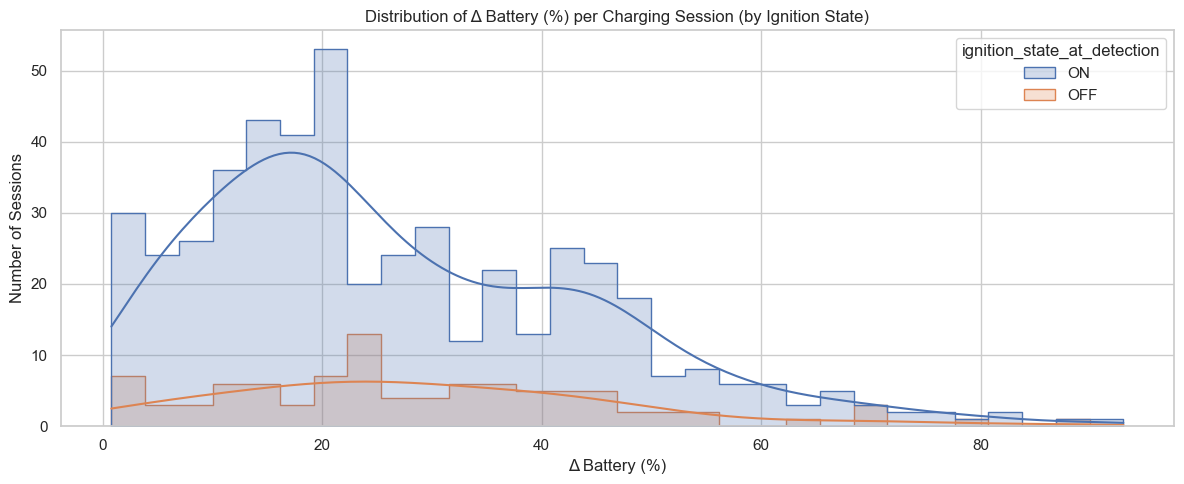

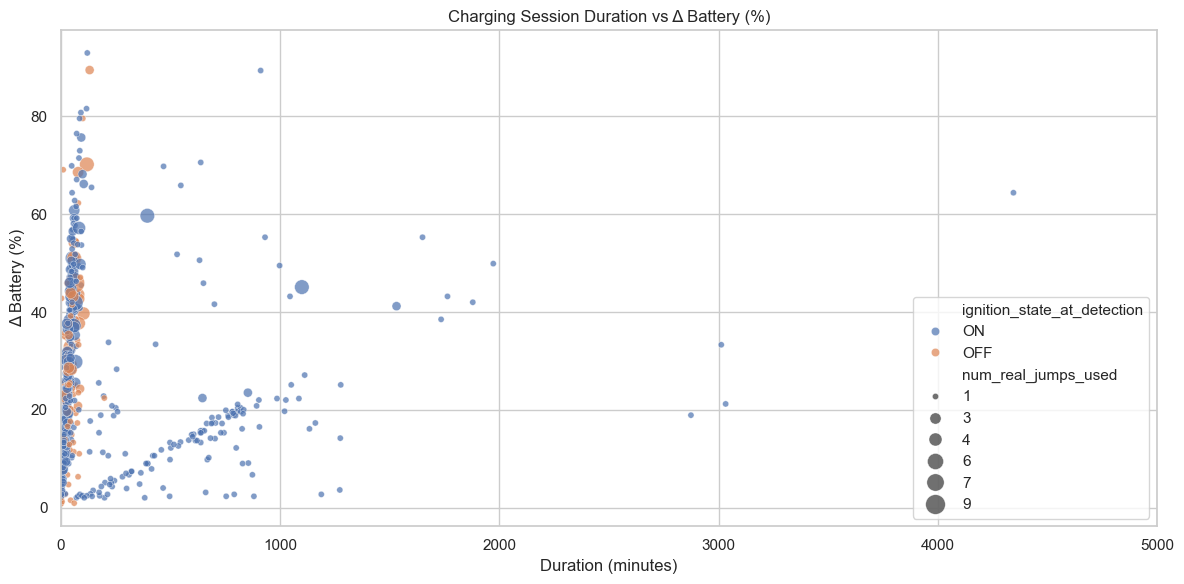

In [59]:
# graphs

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PROCESSED_DIR = Path(r"C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed")
path = PROCESSED_DIR / "ChargingEvents_BatteryDelta.csv"

df = pd.read_csv(path)

# Basic cleaning
df["delta_battery"] = pd.to_numeric(df["delta_battery"], errors="coerce")
df["duration_mins"] = pd.to_numeric(df["duration_mins"], errors="coerce")
df = df.dropna(subset=["delta_battery", "duration_mins"])

sns.set_theme(style="whitegrid")

# -----------------------------
# Plot 1: Δ Battery distribution
# -----------------------------
plt.figure(figsize=(12, 5))
sns.histplot(
    data=df,
    x="delta_battery",
    hue="ignition_state_at_detection",
    bins=30,
    kde=True,
    element="step",
    stat="count",
    common_norm=False
)
plt.title("Distribution of Δ Battery (%) per Charging Session (by Ignition State)")
plt.xlabel("Δ Battery (%)")
plt.ylabel("Number of Sessions")
plt.tight_layout()
plt.show()

# ---------------------------------
# Plot 2: Duration vs Δ Battery
# ---------------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x="duration_mins",
    y="delta_battery",
    hue="ignition_state_at_detection",
    size="num_real_jumps_used",
    sizes=(20, 200),
    alpha=0.7
)

plt.xlim(0, 5000)   # hides the 40,000 min anomaly
plt.title("Charging Session Duration vs Δ Battery (%)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Δ Battery (%)")
plt.tight_layout()
plt.show()


In [39]:
# checking parquet files (optional)

import polars as pl
from pathlib import Path

# Adjust if needed
PROCESSED_DIR = Path(r"C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed")

files_to_check = {
    "tlm_clean.parquet": "TLM (telemetry)",
    "trg_clean.parquet": "TRG (triggers)",
    "mapping.parquet": "MAP (vehicle-PNID mapping)",
    "syn_clean.parquet": "SYN (synthetic overrides)",
}

for filename, description in files_to_check.items():
    path = PROCESSED_DIR / filename
    
    print("\n" + "═" * 70)
    print(f"CHECKING FILE: {filename}  ({description})")
    print("═" * 70)
    
    if not path.exists():
        print("→ File does NOT exist! Check your cleaning script output path.")
        continue
    
    try:
        df = pl.read_parquet(path)
        
        print(f"Rows:          {df.height:,}")
        print(f"Columns:       {df.columns}")
        print(f"Schema:\n{df.schema}")
        
        # Key columns presence & nulls
        key_cols = ["vehicle_id", "ts_utc", "event_ts", "IGNITION_STATUS", "NAME", "VAL"]
        for col in key_cols:
            if col in df.columns:
                nulls = df[col].null_count()
                print(f"  {col:15} → nulls: {nulls:,} ({nulls/df.height:.1%})")
        
        # Time range if timestamp present
        ts_col = next((c for c in ["ts_utc", "event_ts"] if c in df.columns), None)
        if ts_col:
            min_ts = df[ts_col].min()
            max_ts = df[ts_col].max()
            print(f"Time range ({ts_col}): {min_ts} → {max_ts}")
        
        # Quick sample (first 3 rows)
        print("\nFirst 3 rows:")
        print(df.head(3))
        
        # Source-specific quick insights
        if "IGNITION_STATUS" in df.columns:
            print("\nIGNITION_STATUS value counts (top 5):")
            print(df["IGNITION_STATUS"].value_counts().head(5))
        
        if "NAME" in df.columns:
            print("\nTRG NAME value counts (top 5):")
            print(df["NAME"].value_counts().head(5))
        
        if "vehicle_id" in df.columns:
            print(f"Unique vehicle_ids: {df['vehicle_id'].n_unique():,}")
        
    except Exception as e:
        print(f"→ ERROR reading file: {e}")


══════════════════════════════════════════════════════════════════════
CHECKING FILE: tlm_clean.parquet  (TLM (telemetry))
══════════════════════════════════════════════════════════════════════
Rows:          1,833,552
Columns:       ['vehicle_id', 'ts_utc', 'IGNITION_STATUS', 'EV_BATTERY_LEVEL', 'ODOMETER']
Schema:
Schema({'vehicle_id': String, 'ts_utc': Datetime(time_unit='us', time_zone=None), 'IGNITION_STATUS': String, 'EV_BATTERY_LEVEL': Float64, 'ODOMETER': Float64})
  vehicle_id      → nulls: 0 (0.0%)
  ts_utc          → nulls: 0 (0.0%)
  IGNITION_STATUS → nulls: 1,604,060 (87.5%)
Time range (ts_utc): 2021-09-01 00:00:02 → 2023-01-30 23:59:58.000018

First 3 rows:
shape: (3, 5)
┌─────────────────────────────────┬───┐
│ vehicle_id                      ┆ … │
│ ---                             ┆   │
│ str                             ┆   │
╞═════════════════════════════════╪═══╡
│ 026af092-a01e-4b0a-af38-f45972… ┆ … │
│ …                               ┆ … │
└────────────────────────

Motorq Data Science Assignment - 2024/
│
├── vehicle_pnid_mapping.csv
├── triggers_soc.csv
├── telemetry_data.csv
├── artificial_ign_off_data.json
│
└── processed/
    ├── mapping.parquet
    ├── syn_clean.parquet
    ├── trg_clean.parquet
    ├── tlm_clean.parquet
    ├── IgnitionEvents.csv
    ├── IgnitionEvents.parquet
    ├── ChargingStatusEvents.csv
    ├── AssociatedBatteryEvents.csv
    └── Final_Charging_Sessions_Summary.csv


## Milestone 1

    -Objective: Clean and normalize raw data from mapping, synthetic ignition, trigger logs, and telemetry for downstream analysis.
    -Key Methods:
        -JSON parsing of vehicle-to-PNID mapping.
        -Timestamp normalization and UTC conversion.
        -Robust datetime parsing with multi-format support.
        -Data sanitization (clipping values, deduplication).
        -Lazy loading and Parquet output for scalability.
    -Assumptions:
        -All timestamps are in UTC; timezone awareness is critical.
        -Data sources are generally well-formed but require cleaning.
        -Mapping between vehicles and PNIDs is comprehensive and up-to-date.
    -Insights:
        -Cleaned datasets ensure consistent timestamps and vehicle IDs.
        -Efficient processing scales to large datasets.
        -Standardized outputs enable accurate joins and comparisons in subsequent steps.
## Milestone 2
    
    -Objective: Extract and consolidate ignition events from multiple sources.
    -Key Methods:
        -Event detection from TLM, TRG, and SYN using forward-fill and change detection.
        -Source prioritization and deduplication via window clustering.
        -Timezone-aware timestamp standardization.
    -Assumptions:
        -Multiple sources may report overlapping ignition events; a 30-second dedup window is used.
        -SYN events are prioritized for overrides.
    -Insights:
        -Unified ignition log reduces noise and ensures reliable state tracking.
        -Prioritization and deduplication improve data quality for charging inference.

## Milestone 3

    -Objective: Infer charging-related events from trigger logs.
    -Key Methods:
        -Session boundary detection via time gaps.
        -Event labeling using explicit strings and fallback logic.
        -Efficient sessionization using group-by and shift operations.
    -Assumptions:
        -Trigger names containing "CHARGE" are valid charging events.
        -A 30-minute gap indicates a new session.
    -Insights:
        -Accurate detection of charging start/end events enables session-level analysis.
        -Fallback logic addresses missing explicit status strings.

## Milestone 4


    -Objective: Associate battery readings with ignition/charging events.
    -Key Methods:
        -Nearest-neighbor join using asof with ±300s tolerance.
        -Success rate computation for association coverage.
    -Assumptions:
        -Battery readings are available within 300 seconds of the event.
        -Naive timestamps (UTC) are used for join consistency.
    -Insights:
        -Event-level battery context improves charging analytics.
        -Association success rate provides a KPI for data completeness.


## Milestone 5


    -Objective: Detect real charging sessions directly from battery behavior instead of relying only on trigger messages.
    -Key Insights:
        -Loaded enriched event timeline
        -Attached ignition state context
        -Time-joined telemetry ignition status to each event to understand vehicle condition during battery changes.
        -Computed battery deltas between consecutive events
        -Measured real change in battery percentage over time per vehicle.
        -Applied adaptive noise filtering
        -Different thresholds based on ignition state:

Stricter when ignition ON (to avoid false rises)

Lenient when ignition OFF (normal charging behavior)

5. Detected real charging “jumps”
Only significant battery increases counted as charging signals.

6. Sessionized continuous jumps
Grouped close jumps into single charging sessions using time gaps.

## Net SoC Gain Distribution (Histogram)


    -This plot shows how much battery percentage vehicles typically gain per charging session.
    -What it reveals:
        Most charging sessions cluster around moderate battery gains
        Very small gains indicate short or interrupted charges
        Large gains represent full or near-full charging cycles
    -Business takeaway:
        -Helps understand typical charging behavior and identify inefficient or abnormal sessions.


## Charging Duration vs Net Battery Gain (Scatter Plot)

    -This plot compares how long charging takes versus how much battery is actually gained.
    -What it reveals:
        -clear positive relationship between time spent charging and energy gained
        -Failed/aborted sessions stand out with low gain despite long duration
        -Extreme outliers highlight sensor or sessionization anomalies
    -Business takeaway:
        -Used to evaluate charging efficiency and quickly spot problematic chargers or vehicles.


        

In [54]:
import polars as pl
import os
from pathlib import Path

PROCESSED_DIR = Path(r"C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed")

# ---------------------------
# Tunable business parameters
# ---------------------------
ASOF_TOL = "300s"                 # ignition association tolerance
SESSION_GAP_MINS = 30             # gap to start new session (debounce)
THRESH_IGN_OFF = 0.5              # real jump if ignition OFF
THRESH_IGN_ON  = 2.0              # stricter when ignition ON (per prompt hint)

def detect_charging_events_from_battery():
    print("="*60)
    print("MILESTONE 5 (REVISED): BATTERY-DELTA CHARGING EVENT DETECTION")
    print("="*60)

    cand_path = PROCESSED_DIR / "AssociatedBatteryEvents.csv"
    tlm_path  = PROCESSED_DIR / "tlm_clean.parquet"
    out_path  = PROCESSED_DIR / "ChargingEvents_BatteryDelta.csv"

    if not cand_path.exists():
        raise FileNotFoundError("Missing AssociatedBatteryEvents.csv (run Milestone 4).")
    if not tlm_path.exists():
        raise FileNotFoundError("Missing tlm_clean.parquet (run Milestone 1).")

    # 1) Load candidate events with battery snapshot
    cand = (
        pl.read_csv(cand_path)
        .with_columns(
            pl.col("event_ts").str.to_datetime(strict=False).dt.replace_time_zone(None),
            pl.col("battery_level").cast(pl.Float64, strict=False)
        )
        .select(["vehicle_id", "event", "event_ts", "battery_level"])
        .filter(pl.col("event_ts").is_not_null())
        .sort(["vehicle_id", "event_ts"])
    )

    # 2) Load telemetry ignition status timeline
    tlm = (
        pl.read_parquet(tlm_path)
        .select([
            "vehicle_id",
            pl.col("ts_utc").alias("tlm_ts"),
            "IGNITION_STATUS",
        ])
        .with_columns(pl.col("tlm_ts").dt.replace_time_zone(None))
        .sort(["vehicle_id", "tlm_ts"])
    )

    # Normalize ignition to a simple ON/OFF label for thresholding
    tlm = tlm.with_columns(
        pl.when(pl.col("IGNITION_STATUS").cast(pl.Utf8).str.to_lowercase().str.contains(r"on|1|true"))
          .then(pl.lit("ON"))
          .when(pl.col("IGNITION_STATUS").cast(pl.Utf8).str.to_lowercase().str.contains(r"off|0|false"))
          .then(pl.lit("OFF"))
          .otherwise(None)
          .alias("ign_state")
    )

    # 3) Attach ignition state at candidate-event time (nearest within ±300s)
    cand_with_ign = cand.join_asof(
        tlm,
        left_on="event_ts",
        right_on="tlm_ts",
        by="vehicle_id",
        strategy="nearest",
        tolerance=ASOF_TOL
    ).select([
        "vehicle_id", "event", "event_ts", "battery_level",
        pl.col("ign_state").alias("ignition_state_at_event")
    ])

    # We need battery snapshots to compute deltas
    cand_with_ign = cand_with_ign.filter(pl.col("battery_level").is_not_null())

    # 4) Compute delta battery between consecutive candidate events per vehicle
    deltas = (
        cand_with_ign
        .with_columns([
            pl.col("battery_level").shift(1).over("vehicle_id").alias("prev_battery"),
            pl.col("event_ts").shift(1).over("vehicle_id").alias("prev_ts"),
            pl.col("ignition_state_at_event").shift(1).over("vehicle_id").alias("prev_ign_state"),
        ])
        .with_columns(
            (pl.col("battery_level") - pl.col("prev_battery")).alias("delta_battery")
        )
        .filter(pl.col("prev_battery").is_not_null())
    )

    # 5) Apply real-jump threshold (stricter when ignition is ON)
    deltas = deltas.with_columns(
        pl.when(pl.col("ignition_state_at_event") == "ON")
          .then(pl.lit(THRESH_IGN_ON))
          .otherwise(pl.lit(THRESH_IGN_OFF))
          .alias("real_jump_threshold")
    ).with_columns(
        (pl.col("delta_battery") >= pl.col("real_jump_threshold")).alias("is_real_jump")
    )

    real_jumps = deltas.filter(pl.col("is_real_jump") == True).sort(["vehicle_id", "event_ts"])

    # 6) Debounce: sessionize real jumps so we don't double-count continuous charging
    real_jumps = real_jumps.with_columns(
        (pl.col("event_ts").diff().over("vehicle_id") > pl.duration(minutes=SESSION_GAP_MINS))
        .fill_null(True)
        .alias("new_session")
    ).with_columns(
        pl.col("new_session").cast(pl.Int64).cum_sum().over("vehicle_id").alias("session_id")
    )

    # 7) Aggregate into ChargingEvents (one row per continuous charging session)
    charging_events = (
        real_jumps.group_by(["vehicle_id", "session_id"])
        .agg([
            pl.min("prev_ts").alias("start_ts"),
            pl.max("event_ts").alias("end_ts"),
            pl.first("prev_battery").alias("start_soc"),
            pl.last("battery_level").alias("end_soc"),
            (pl.last("battery_level") - pl.first("prev_battery")).alias("delta_battery"),
            pl.first("ignition_state_at_event").alias("ignition_state_at_detection"),
            pl.len().alias("num_real_jumps_used"),
        ])
        .with_columns(
            ((pl.col("end_ts") - pl.col("start_ts")).dt.total_seconds() / 60).alias("duration_mins")
        )
        .sort(["vehicle_id", "start_ts"])
    )

    charging_events.write_csv(out_path)

    # 8) Summary metrics (optional)
    total = charging_events.height
    avg_gain = charging_events.select(pl.col("delta_battery").mean()).item()
    print(f"\nSaved: {out_path}")
    print(f"Total ChargingEvents detected: {total}")
    print(f"Average Δ battery per ChargingEvent: {avg_gain:.2f}%")
    print("\nPreview:")
    print(charging_events.head(10))

if __name__ == "__main__":
    detect_charging_events_from_battery()

MILESTONE 5 (REVISED): BATTERY-DELTA CHARGING EVENT DETECTION

Saved: C:\Users\aniruktha\Downloads\Motorq Data Science Assignment - 2025\Motorq Data Science Assignment - 2024\processed\ChargingEvents_BatteryDelta.csv
Total ChargingEvents detected: 734
Average Δ battery per ChargingEvent: 25.90%

Preview:
shape: (10, 10)
┌─────────────────────────────────┬───┐
│ vehicle_id                      ┆ … │
│ ---                             ┆   │
│ str                             ┆   │
╞═════════════════════════════════╪═══╡
│ 56d8ca94-9b18-41d1-831f-7afd90… ┆ … │
│ …                               ┆ … │
└─────────────────────────────────┴───┘


C:\Users\aniruktha\AppData\Local\Temp\ipykernel_33980\1749184740.py:64: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  cand_with_ign = cand.join_asof(
